In [1]:
# **********************************************************************************
# Helper functions
# **********************************************************************************
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import numpy as np
import cv2
import glob
from skimage.feature import hog





# **********************************************************************************
# Low level Building block functions
# **********************************************************************************
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 255)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function that masks all heat pixels corresponding to cars detected in previous 
# frames
def apply_car_tracking_mask(heat, list_detected_cars):
    mask = np.zeros_like(heat)
    masked_heat = np.zeros_like(heat)
    # Iterate through list of bboxes
    for box in list_detected_cars:
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        mask[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    masked_heat[mask > 0] = heat[mask > 0]
    # Return updated heatmap
    return masked_heat
    

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes


   
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    detected_cars_list = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        detected_cars_list.append(bbox)
    # Return the image and list of bounding boxes for detected cars
    return img, detected_cars_list
# **********************************************************************************
# **********************************************************************************


# **********************************************************************************
# Extract features for a single window or patch of image
# **********************************************************************************
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        #normalize images to be in 0-255 uint8
        image = np.round(image/(np.max(image))*255).astype('uint8')
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)                
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# **********************************************************************************
# **********************************************************************************
def find_cars(img, xstart, xstop, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space):
    
    #normalize image to be in 0-255 uint8
    img = np.round(img/(np.max(img))*255).astype('uint8')
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
        
    ctrans_tosearch = feature_image[ystart:ystop,xstart:xstop]
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            # Sameer: resizing not needed.
            # subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            subimg = ctrans_tosearch[ytop:ytop+window, xleft:xleft+window]
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale) + xstart
                ytop_draw = np.int(ytop*scale) + ystart
                win_draw = np.int(window*scale)                
                bbox.append(((xbox_left,ytop_draw),
                             (xbox_left+win_draw,ytop_draw+win_draw)))
              
    return bbox

# Class to track detected car history and eliminate false detections
class BboxHistory():
    def __init__(self, maxLen):
        self.bboxlist = []
        self.carlist = []
        self.boxptr = 0  
        self.carptr = 0
        self.maxBoxLen = maxLen
        self.maxCarLen = np.int(maxLen/3)
    def addBoxList(self, bblist):
        if len(self.bboxlist) <= self.maxBoxLen:
            self.bboxlist.append(bblist)
        else:
            self.bboxlist[self.boxptr] = bblist
        self.boxptr = (self.boxptr + 1) % self.maxBoxLen
    def getBoxList(self):
        return [item for sublist in self.bboxlist for item in sublist]


    def addCarList(self, bblist):
        if len(self.carlist) <= self.maxCarLen:
            self.carlist.append(bblist)
        else:
            self.carlist[self.carptr] = bblist
        self.carptr = (self.carptr + 1) % self.maxCarLen

    def getCarList(self):
        return [item for sublist in self.carlist for item in sublist]
    

  


    

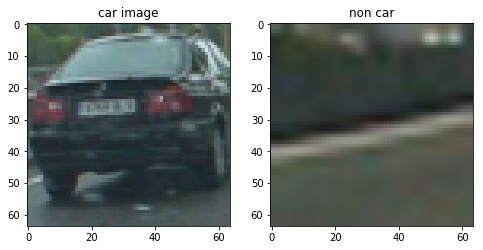

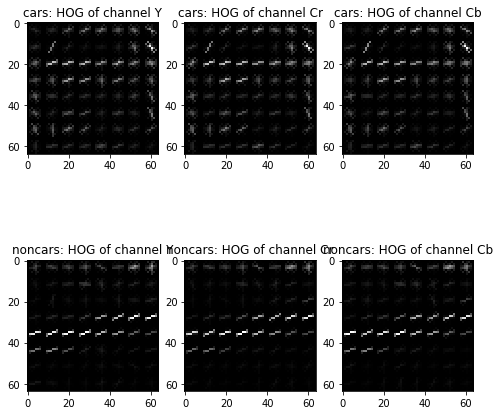

In [2]:
# display car and non car images
noncars = glob.glob('./non-vehicles/GTI/*.png')
cars    = glob.glob('./vehicles/GTI_Left/*.png')
car_img_fname = cars[0]
noncar_img_fname = noncars[30]

fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 1
# Read a car example
img = mpimg.imread(car_img_fname)
fig.add_subplot(rows, columns, 1)  
plt.title('car image')
plt.imshow(img)
# Read a non car example
img = mpimg.imread(noncar_img_fname)
fig.add_subplot(rows, columns, 2)   
plt.title('non car')
plt.imshow(img)
plt.show()

# HOG parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
car_img = mpimg.imread(car_img_fname)
noncar_img = mpimg.imread(noncar_img_fname)
    
features, hog_image_chY = get_hog_features(car_img[...,0], orient, pix_per_cell, cell_per_block, vis=True)
features, hog_image_chCr = get_hog_features(car_img[...,1], orient, pix_per_cell, cell_per_block, vis=True)
features, hog_image_chCb = get_hog_features(car_img[...,2], orient, pix_per_cell, cell_per_block, vis=True)

fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 2
fig.add_subplot(rows, columns, 1)
plt.title('cars: HOG of channel Y')
plt.imshow(hog_image_chY, cmap = 'gray')
fig.add_subplot(rows, columns, 2)
plt.title('cars: HOG of channel Cr')
plt.imshow(hog_image_chCr, cmap = 'gray')
fig.add_subplot(rows, columns, 3)
plt.title('cars: HOG of channel Cb')
plt.imshow(hog_image_chCb, cmap = 'gray')


features, hog_image_chY = get_hog_features(noncar_img[...,0], orient, pix_per_cell, cell_per_block, vis=True)
features, hog_image_chCr = get_hog_features(noncar_img[...,1], orient, pix_per_cell, cell_per_block, vis=True)
features, hog_image_chCb = get_hog_features(noncar_img[...,2], orient, pix_per_cell, cell_per_block, vis=True)
fig.add_subplot(rows, columns, 4)
plt.title('noncars: HOG of channel Y')
plt.imshow(hog_image_chY, cmap = 'gray')
fig.add_subplot(rows, columns, 5)
plt.title('noncars: HOG of channel Cr')
plt.imshow(hog_image_chCr, cmap = 'gray')
fig.add_subplot(rows, columns, 6)
plt.title('noncars: HOG of channel Cb')
plt.imshow(hog_image_chCb, cmap = 'gray')
plt.show()


In [3]:
# **********************************************************************************
# Training SVM classifier
# **********************************************************************************
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn import svm, grid_search, datasets
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split

TRAIN_CLASSIFIER = False 
if TRAIN_CLASSIFIER:
    # Read in cars and notcars
    print('started:',time.time())
    cars = []
    notcars = []
    images = glob.glob('./non-vehicles/GTI/*.png')
    notcars = notcars + images
    images = glob.glob('./non-vehicles/Extras/*.png')
    notcars = notcars + images

    images = glob.glob('./vehicles/GTI_Left/*.png')
    cars = cars + images
    images = glob.glob('./vehicles/GTI_Right/*.png')
    cars = cars + images
    images = glob.glob('./vehicles/GTI_Far/*.png')
    cars = cars + images
    images = glob.glob('./vehicles/GTI_MiddleClose/*.png')
    cars = cars + images
    images = glob.glob('./vehicles/KITTI_extracted/*.png')
    cars = cars + images    

    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 64    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    print('Now extracting features: ', time.time())

    t=time.time()
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract features...')

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    t=time.time()
    # Check the training time for the SVC
    svc.fit(X_train, y_train)
    dist_pickle = {}
    # get attributes of our svc object
    dist_pickle["color_space"] = color_space
    dist_pickle["orient"] = orient
    dist_pickle["pix_per_cell"] = pix_per_cell
    dist_pickle["cell_per_block"] = cell_per_block
    dist_pickle["hog_channel"] = hog_channel
    dist_pickle["spatial_size"] = spatial_size
    dist_pickle["hist_bins"] = hist_bins
    dist_pickle["spatial_feat"] = spatial_feat
    dist_pickle["hist_feat"] =  hist_feat
    dist_pickle["hog_feat"] = hog_feat
    dist_pickle["svc"] = svc
    dist_pickle["scaler"] = X_scaler

    picklefname = 'svc_' + color_space + '.pickle'
    pickle.dump(dist_pickle, open(picklefname, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC with colorspace ', color_space, ' is', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()

/home/sameerp/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/sameerp/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


started: 1534232662.4028928
Now extracting features:  1534232662.4618716
133.37 Seconds to extract features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6252
14.48 Seconds to train SVC...
Test Accuracy of SVC with colorspace  LUV  is 0.9845


In [ ]:
# **********************************************************************************
# Image processing pipeline
# **********************************************************************************
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label



# Load the classifier and related parameters
color_space = 'YCrCb'
picklefname = 'svc_' + color_space + '.pickle'
dist_pickle = pickle.load( open(picklefname, "rb" ) )
color_space = dist_pickle["color_space"]
orient = dist_pickle["orient"] # HOG orientations
pix_per_cell = dist_pickle["pix_per_cell"] # HOG pixels per cell
cell_per_block = dist_pickle["cell_per_block"] # HOG cells per block
hog_channel = dist_pickle["hog_channel"] # Can be 0, 1, 2, or "ALL"
spatial_size = dist_pickle["spatial_size"] # Spatial binning dimensions
hist_bins = dist_pickle["hist_bins"]    # Number of histogram bins
spatial_feat = dist_pickle["spatial_feat"] # Spatial features on or off
hist_feat = dist_pickle["hist_feat"] # Histogram features on or off
hog_feat = dist_pickle["hog_feat"] # HOG features on or off
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]

heat_threshold  = 105
bboxes_hist = BboxHistory(15)

def process_image(image):    
    scale_array  = [1, 1.5, 4]
    ystop_array  = [550, 550, 650]
    current_frame_bbox_list = []
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    for s in range(len(scale_array)):
        scale = scale_array[s]
        xstart = 250
        xstop = 1280
        ystart = 400
        ystop = ystop_array[s]
        
        hot_windows = find_cars(image, xstart, xstop, ystart, ystop, scale, svc, 
                  X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
        current_frame_bbox_list.extend(hot_windows) 

    
    # update detected box history
    bboxes_hist.addBoxList(current_frame_bbox_list)
    
    # get the Box history
    bboxlist = bboxes_hist.getBoxList()
    
    # Add heat to each box in box list in history class
    heat = add_heat(heat, bboxlist)    
    car_tracking_masked_heat = apply_car_tracking_mask(heat, bboxes_hist.getCarList())
    
    # Apply threshold to help remove false positives
    thresholded_heat  = apply_threshold(heat,heat_threshold)
    car_tracking_heat = apply_threshold(car_tracking_masked_heat, 20)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(thresholded_heat + car_tracking_heat, 0, 255)
    

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    window_img, detected_cars_bbox_list = draw_labeled_bboxes(np.copy(image), labels)       
    
    # update detected car history for this frame
    bboxes_hist.addCarList(detected_cars_bbox_list)    
    
    return window_img

In [ ]:
# **********************************************************************************
# Video processing pipeline
# **********************************************************************************
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'test_videos_output/project_video.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)